In [17]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from glob import glob

In [8]:
def load_iris_csv(file_path):
     """Loads a dataset expecting the last column to be the target of a prediction.
    Extracts all preceding columns into X and encodes the y labels. Returns
    X, y, feature_names and the encoded class names."""

     original_df = pd.read_csv(file_path)
     X_df = original_df.iloc[:, :-1]
     X = X_df.to_numpy()
     y = original_df.iloc[:, -1].to_numpy().ravel()

     le = LabelEncoder()
     y = le.fit_transform(y)

     class_names = le.classes_
     feature_names = X_df.columns

     return X, y, feature_names, class_names

In [9]:
def kfold_crossval(classifier, X, y, k=10):
    """Function to evaluate a scikit learn model in 10-fold shuffled
    split cross validation. 
    """
    # TODO: cange losses to scores
    stratified_shuffled_kfold = StratifiedShuffleSplit(n_splits=k, train_size=0.9, random_state=42)
    val_losses = np.empty((k,))
    train_losses = np.empty((k,))

    for i, (train_index, val_index) in enumerate(stratified_shuffled_kfold.split(X, y)): 

        # scikit learn implementation of shuffled cross_validation
        # defines splits by returning indices to the provided np arrays
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # all scikit-learn estimators provide a fit function for training
        classifier.fit(X_train, y_train)

        y_val_pred = classifier.predict(X_val)
        y_train_pred = classifier.predict(X_train)            
        val_losses[i] = accuracy_score(y_val, y_val_pred)
        train_losses[i] = accuracy_score(y_train, y_train_pred)

        mean_val_loss = np.mean(val_losses)
        mean_train_loss = np.mean(train_losses)
        
    return mean_val_loss, mean_train_loss

In [10]:
def find_best_classifer_hyperparam(
    X, y, classifier, hyperparam_name, hyperparam_values
):
    """Performs a search for the optimal hyperparameters based on 10-fold cross-validation.
    The function receives a design (feature) matrix X, a vector of class labels y, a scikit-learn
    classifier classifier, the name hyperparam_name of the hyperparameter to be optimized, and a
    list hyperparam_values with the values to be tested for the hyperparameter. The function
    returns the classifier trained on the entire training dataset with the best hyperparameter
    value and the best hyperparameter value."""

    """Tests different classifiers for different values of a hyper parameter given to the function."""

    mean_val_scores = np.empty((len(hyperparam_values),))
    mean_train_scores  = np.empty((len(hyperparam_values),))

    for i, val in enumerate(hyperparam_values):
        # set the regularization for each evaluation of the path
        classifier.set_params(**{hyperparam_name: val})
        
        mean_val_score, mean_train_score = kfold_crossval(classifier=classifier, X=X, y=y)
        
        mean_val_scores[i] = mean_val_score
        mean_train_scores[i] = mean_train_score
                
    idx = np.argmax(mean_val_scores)

    best_hyperparam = hyperparam_values[idx]

    classifier.set_params(**{hyperparam_name: best_hyperparam})
    classifier.fit(X, y)

    return classifier, best_hyperparam

# 2-D Dataset

In [18]:
X, y, feature_names, class_names = load_iris_csv("./iris_2D.csv")

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
classifier = KNeighborsClassifier()
best_classifier, k = find_best_classifer_hyperparam(X_train, y_train, classifier, "n_neighbors", range(1, 15))

print(f"Best k for classification: {k}")

Best k for classification: 12


Text(0.5, 0.98, 'Classification results kNN 2-D-Iris-Test-Set')

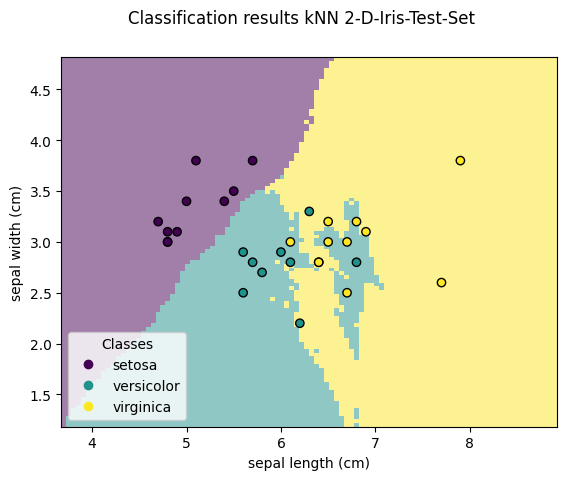

In [21]:
fig, ax = plt.subplots()

disp = DecisionBoundaryDisplay.from_estimator(
    best_classifier,
    X_test,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel=feature_names[0],
    ylabel=feature_names[1],
    shading="auto",
    alpha=0.5,
    ax=ax
)

scat = disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors="k", label="Classes")

disp.ax_.legend(
    scat.legend_elements()[0],
    class_names,
    loc="lower left",
    title="Classes",
)

fig.suptitle("Classification results kNN 2-D-Iris-Test-Set")

Text(0.5, 0.98, 'Classification results kNN 2-D-Iris-Test-Set\nRed circles indicate train data points')

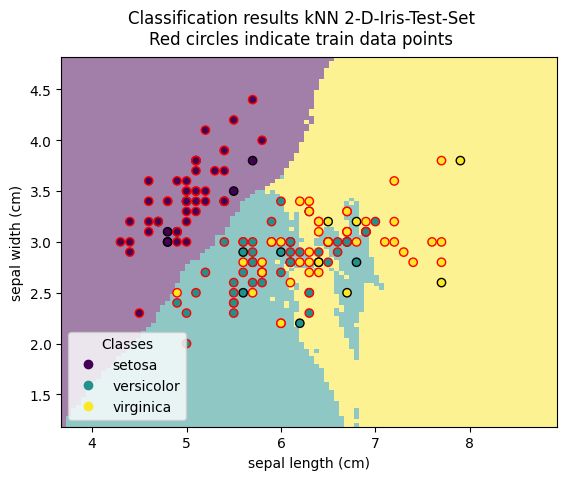

In [22]:
fig, ax = plt.subplots()

disp = DecisionBoundaryDisplay.from_estimator(
    best_classifier,
    X_test,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel=feature_names[0],
    ylabel=feature_names[1],
    shading="auto",
    alpha=0.5,
    ax=ax
)

scat = disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors="k", label="Classes")
scat_train = disp.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="red")

disp.ax_.legend(
    scat.legend_elements()[0],
    class_names,
    loc="lower left",
    title="Classes",
)

fig.suptitle("Classification results kNN 2-D-Iris-Test-Set\nRed circles indicate train data points")

# Iris comaprison original, random, scaled

## Load Datasets

In [23]:
X_orig, y_orig, feature_names_orig, class_names_orig = load_iris_csv("./iris_original.csv")
X_rand, y_rand, feature_names_rand, class_names_rand = load_iris_csv("./iris_randfeatures.csv")
X_scaled, y_scaled, feature_names_scaled, class_names_scaled = load_iris_csv("./iris_scaledfeatures.csv")

## Class prediction without scaling

In [24]:
classifier = KNeighborsClassifier()

print("Results, no preprocessing:")
print("__________________________")
print("")
for dataset_path in glob("iris_*.csv"):
    if "2D" in dataset_path:
        continue

    X, y, feature_names, class_names = load_iris_csv(dataset_path)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_classifier, k = find_best_classifer_hyperparam(X_train, y_train, classifier, "n_neighbors", range(1, 15))
    best_classifier.fit(X_train, y_train)

    y_hat_test = best_classifier.predict(X_test)

    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_hat_test)

    print(f"Dataset: {dataset_path.split('/')[-1]}", end="\n")
    print(f"Best k: {k}, accuracy: {test_accuracy}")

Results, no preprocessing:
__________________________

Dataset: iris_original.csv
Best k: 3, accuracy: 1.0
Dataset: iris_randfeatures.csv
Best k: 9, accuracy: 0.8
Dataset: iris_scaledfeatures.csv
Best k: 1, accuracy: 0.8333333333333334


In [ ]:
# Task 1:
# TODO:
# Load 2-D dataset
# What about a test set?
# Find best k for kNN model
# Visualize test set predictions
# prediction surfaces -> see scikit-learn documentation and exercise sheet

In [ ]:
# Task 2:
# TODO:
# Load Datasets
# For each dataset
# what about a test set?
# Finds best k for kNN model
# report best accuracy
# For each dataset
# Try the same, but scale the data before